# CS418 : MoneyMapping In Chicago

By: Saja Bushara, Sadika Almasri, Joshua Adereti, Freya Modi and Alisha Zaidi

This project examines how loans and grants in Chicago are distributed across neighborhoods, focusing on whether that distribution is equitable. Using datasets from SBIF, NOF, and other city funding programs related to loans alongside demographic data, we aim to answer our guiding questions:

Are loans/grants in Chicago distributed equitably across neighborhoods? and How do socioeconomic/demographic factors relate to that distribution?

In [127]:
#IGNORE... this is set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#this is just a checker to make sure the csv's r being loaded, disregard
def read_csv_any(p):
    try:
        return pd.read_csv(p, low_memory=False)
    except UnicodeDecodeError:
        return pd.read_csv(p, encoding="latin-1", low_memory=False)

paths = {
    "cmi_loans": "../Datasets/CMI_Microloans.csv",
    "cmi_demo": "../Datasets/CMI_Microloans_By_Ethnicity_Gender.csv",
    "nof": "../Datasets/NOF_Small_Projects_2025.csv",
    "sbif": "../Datasets/SBIF_Applicants_Small_Business_Projects_2025.csv",
    "socio_old": "../Datasets/Socioecon_Community_2008_2012.csv",
    "socio_new": "../Datasets/Socioeconomic_Neighborhoods_2025.csv.csv",
    "socio_by_ca": "../Datasets/chi_data_tract.csv",
}


dfs = {k: read_csv_any(p) for k,p in paths.items()}

# for name, df in dfs.items():
#     print(f"\n{name}: {df.shape[0]:,} rows and {df.shape[1]} cols")
#     print(df.columns.tolist()[:12])
#     print(df.head(3))


# Cleaned Data

### Grants

By: Saja Bushara 

Although the SBIF and NOF grant datasets were structured, they required multiple cleaning steps before analysis. First, we standardized column names by stripping whitespace to ensure consistent indexing. Values such as “INCENTIVE AMOUNT” and “TOTAL PROJECT COST” were originally stored as strings containing dollar signs, commas, and spaces. We cleaned these using a custom helper function that removes non-numeric characters and converts the fields into numeric types. Because several projects reported a total project cost of $0, which would cause division errors, we replaced zero values with NaN to avoid invalid calculations.

From this we computed the Grant Ratio (later converted to %) metric =

incentive amount/total project cost

which serves as a key measure of how much of a project’s budget was covered by a grant. Finally, we grouped projects by Community Area to summarize grant volume, median coverage percentage, and total dollars awarded across neighborhoods.

Cleaning code is below:

In [128]:
# By Saja Bushara

for prog in ["sbif", "nof"]:
    dfs[prog].columns = dfs[prog].columns.str.strip()

#cleaning all the "$some number" to be nums. curr strings
def to_numeric_clean(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace(r"[^0-9.\-]", "", regex=True),
        errors="coerce"
    )

#grant ratios = INCENTIVE AMOUNT ÷ TOTAL PROJECT COST, this tells us what share of each project’s total request was covered by the EACH grant
for prog in ["sbif", "nof"]:
    df = dfs[prog]
    needed = ["INCENTIVE AMOUNT", "TOTAL PROJECT COST", "COMMUNITY AREA"]
    if "INCENTIVE AMOUNT" in df.columns:
        df["INCENTIVE AMOUNT"] = to_numeric_clean(df["INCENTIVE AMOUNT"])
    if "TOTAL PROJECT COST" in df.columns:
        df["TOTAL PROJECT COST"] = to_numeric_clean(df["TOTAL PROJECT COST"])

    #some projects dont actually have a cost so its $0.... if thats the case we dont want to devide lol
    if {"INCENTIVE AMOUNT", "TOTAL PROJECT COST"}.issubset(df.columns):
        denom = df["TOTAL PROJECT COST"].replace(0, np.nan)
        df["GRANT_RATIO"] = df["INCENTIVE AMOUNT"] / denom
    else:
        df["GRANT_RATIO"] = np.nan

    df["GRANT_Percent"] = (df["GRANT_RATIO"] * 100).round(1) #just turning the ratios into % for easier looks

print("SBIF GRANT_Percent summary (%):\n", dfs["sbif"]["GRANT_Percent"].dropna().describe())
print("NOF GRANT_Percent summary (%):\n", dfs["nof"]["GRANT_Percent"].dropna().describe())

print(dfs["sbif"]["GRANT_Percent"].dropna().map(lambda x: f"{x:.1f}%").head())


SBIF GRANT_Percent summary (%):
 count    2150.000000
mean       60.089581
std        18.367201
min         3.300000
25%        50.000000
50%        57.150000
75%        75.000000
max       100.000000
Name: GRANT_Percent, dtype: float64
NOF GRANT_Percent summary (%):
 count    119.000000
mean      54.594118
std       19.543950
min        1.700000
25%       47.850000
50%       52.500000
75%       69.400000
max      100.000000
Name: GRANT_Percent, dtype: float64
0    51.1%
1    49.3%
2    35.2%
3    75.0%
4    75.0%
Name: GRANT_Percent, dtype: object


In [129]:
# By Saja Bushara

#community areas BY project count
print("SBIF:top 20 community areas by count:\n")
print(dfs["sbif"]["COMMUNITY AREA"].value_counts().head(20))


print("NOF:top 20 community areas by count:\n")
print(dfs["nof"]["COMMUNITY AREA"].value_counts().head(20))

#this is just for missing stuff
# print("SBIF missing (top 10):\n")
# print(dfs["sbif"].isna().sum().sort_values(ascending=False).head(10))

# print("NOF missing(top 10):\n")
# print(dfs["nof"].isna().sum().sort_values(ascending=False).head(10))

#this is just checking if the people who applied for sbif maybe also did nof from a parituclar community : SBIF covers the majority of chicago neighborhoods
sbif_areas = set(dfs["sbif"]["COMMUNITY AREA"].dropna().astype(str).str.strip().unique()) if "COMMUNITY AREA" in dfs["sbif"].columns else set()
nof_areas  = set(dfs["nof"]["COMMUNITY AREA"].dropna().astype(str).str.strip().unique())  if "COMMUNITY AREA" in dfs["nof"].columns  else set()

#idk this might be useful, leave this here
print("\nAreas in both SBIF & NOF:", len(sbif_areas & nof_areas))
print("Areas only in SBIF:", len(sbif_areas - nof_areas))
print("Areas only in NOF:",  len(nof_areas - sbif_areas))


# here, we are removing any nulls for community area and %, grouping by commuity area so they show up once and calculating median and mean of those grant %'s
sbif_by_ca = (
    dfs["sbif"].dropna(subset=["COMMUNITY AREA","GRANT_Percent"]).groupby("COMMUNITY AREA")["GRANT_Percent"]
      .agg(count="count", mean="mean", median="median")
      .sort_values("mean", ascending=False)
)

sbif_dollars = (
    dfs["sbif"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]).groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum()
      .sort_values(ascending=False)
)

nof_dollars = (
    dfs["nof"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]).groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum()
      .sort_values(ascending=False)
)
print("\nTotal SBIF dollars by neighborhood (top 20):")
print(sbif_dollars.head(20))

print("\nTotal NOF dollars by neighborhood (top 20):")
print(nof_dollars.head(20))

print("who gets the biggest % coverage by neighborhood")
print(sbif_by_ca.head(30))


SBIF:top 20 community areas by count:

COMMUNITY AREA
Near West Side     160
Portage Park       138
West Town          111
Lincoln Square      88
Logan Square        84
Austin              82
North Center        80
Humboldt Park       79
Edgewater           79
Albany Park         77
Uptown              77
Belmont Cragin      63
New City            58
North Park          56
West Ridge          51
North Lawndale      49
Mount Greenwood     49
Bridgeport          46
Hermosa             41
Jefferson Park      40
Name: count, dtype: int64
NOF:top 20 community areas by count:

COMMUNITY AREA
South Lawndale            15
Grand Boulevard            9
North Lawndale             8
Chicago Lawn               7
Austin                     6
South Shore                6
Avalon Park                5
Auburn Gresham             5
Calumet Heights            5
Greater Grand Crossing     5
Roseland                   5
South Chicago              5
Humboldt Park              4
New City                   4
W

In [130]:
#ignore...used for visualizations
# By Saja Bushara



socio = pd.read_csv("../Datasets/chi_data.csv")

# come back to this later loan stuff later

# socio["loan_amount_per_hh"] = socio["total_loan_amount"] / socio["total_hh"]
# socio["loans_per_1k_hh"] = socio["total_loans"] / (socio["total_hh"] / 100)

# print(socio[["loan_amount_per_hh","non_white_hh_share","ami_shr"]].corr())

socio["community_area"] = socio["community_area"].str.strip().str.lower()
dfs["sbif"]["COMMUNITY AREA"] = dfs["sbif"]["COMMUNITY AREA"].astype(str).str.strip().str.lower()
dfs["nof"]["COMMUNITY AREA"]  = dfs["nof"]["COMMUNITY AREA"].astype(str).str.strip().str.lower()


#just avg of grant % coverage by community area
sbif = dfs["sbif"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()
nof  = dfs["nof"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()

#merging the community areas for sbif and nof-> primary key
merged = socio.merge(sbif, left_on="community_area", right_on="COMMUNITY AREA", how="left").merge(nof, left_on="community_area", right_on="COMMUNITY AREA", how="left")

# note i split these up bc the printing was a mess and it was hard to see, all of this is explained in the readme
print("\ndemographic shares:")
print(merged[["community_area","white_hh_share","black_hh_share","latino_hh_share","non_white_hh_share"]].head(20).to_string(index=False))

print("\nownership shares:")
print(merged[["community_area","white_own_shr","black_own_shr","latino_own_shr","non_white_own_shr"]].head(20).to_string(index=False))

print("\nincome & grant coverage relationship:")
print(merged[["community_area","ami_shr","income_level","low_inc","GRANT_Percent_x","GRANT_Percent_y"]].head(20).to_string(index=False))

#SBIF correlations (GRANT_Percent_x)
sbif_corr = merged[[
    "white_hh_share","black_hh_share","latino_hh_share",
    "non_white_hh_share","ami_shr","GRANT_Percent_x"
]].corr()["GRANT_Percent_x"].drop("GRANT_Percent_x")

print("\nSBIF correlations with neighborhood factors:")
print(sbif_corr.to_string())

# NOF correlations
nof_corr = merged[[
    "white_hh_share","black_hh_share","latino_hh_share",
    "non_white_hh_share","ami_shr","GRANT_Percent_y"
]].corr()["GRANT_Percent_y"].drop("GRANT_Percent_y")

print("\nNOF correlations with neighborhood factors:")
print(nof_corr.to_string())


demographic shares:
    community_area  white_hh_share  black_hh_share  latino_hh_share  non_white_hh_share
       albany park        0.418062        0.047689         0.364065            0.581938
    archer heights        0.281593        0.008170         0.649732            0.718407
     armour square        0.171386        0.091986         0.044605            0.828614
           ashburn        0.143886        0.517315         0.309608            0.856114
    auburn gresham        0.009184        0.959228         0.013805            0.990816
            austin        0.061827        0.811605         0.111939            0.938173
       avalon park        0.018486        0.956033         0.000000            0.981514
          avondale        0.460985        0.029023         0.446657            0.539015
    belmont cragin        0.210503        0.033998         0.726230            0.789497
           beverly        0.585149        0.346440         0.044899            0.414851
        bri

### Loans

By: Freya Modi and Sadika Almasri

..describe how u cleaned and paste code here ( i think)

In [131]:
# By: Freya Modi and Sadika Almasri ... just paste the code here

# Machine Learning and Stat Analysis (1 each)

## By: Freya Modi, Joshua Adereti, and Saja Bushara

3 of our group members worked on models for the loans. We use the 2023 CRA (Community Reinvestment Act) small business loan data for Illinois and filtered for Chicago.

This analysis uses machine learning to predict small business loan access across Chicago neighborhoods based solely on demographic characteristics (race, income, homeownership). The goal is to test whether loan disparities are systematic and predictable, or whether they result from random variation.

If neighborhood demographics can accurately predict loan access, this confirms that disparities are structural rather than coincidental. This approach builds on the loan analysis which found strong correlations between race/income and loan counts, and extends it by quantifying exactly how predictable these patterns are.

In [132]:
# #IGNORE... this is to prep and analyze the data for ML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor

#load illinois loan data and filter for cook county (chicago)
loan_data = pd.read_excel("../Datasets/Illinois-CRA-Compilation-2023.xlsx")
chicago_loans = loan_data[loan_data['County FIPS'] == 17031].copy()

#tract numbers r like 101.00, 102.01 etc -> need to convert to match chi_data format (10100, 10201)
chicago_loans['tract_clean'] = (chicago_loans['Tract'] * 100).astype(int).astype(str)

chi_tract = pd.read_csv("../Datasets/chi_data_tract.csv")
chi_tract['tract_clean'] = chi_tract['tract'].astype(str)

#merge to get community area names for each census tract
chicago_loans = chicago_loans.merge(
    chi_tract[['tract_clean', 'community_area']],
    on='tract_clean',
    how='left'
)

#only keep tracts that matched to chicago community areas (removes suburbs)
chicago_loans = chicago_loans[chicago_loans['community_area'].notna()].copy()

#total loan count = sum of all loan sizes
chicago_loans['total_loan_count'] = (
    chicago_loans['<100K Number'] +
    chicago_loans['100-<250K Number'] +
    chicago_loans['>250K Number']
)

chicago_loans['total_loan_amount'] = (
    chicago_loans['<100K Amount'] +
    chicago_loans['100-<250K Amount'] +
    chicago_loans['>250K Amount']
)

#grouping by community area to get totals for each neighborhood
loans_by_ca = chicago_loans.groupby('community_area').agg({
    'total_loan_count': 'sum',
    'total_loan_amount': 'sum',
}).round(2)

loans_by_ca_clean = loans_by_ca.reset_index()
loans_by_ca_clean['community_area'] = loans_by_ca_clean['community_area'].str.strip().str.lower()

#merge with socio data to get demographics
socio = pd.read_csv("../Datasets/chi_data.csv")
socio['community_area'] = socio['community_area'].str.strip().str.lower()

merged = socio.merge(
    loans_by_ca_clean[['community_area', 'total_loan_count', 'total_loan_amount']],
    on='community_area',
    how='left'
)

#calculating loans per 1k households to normalize by population
merged['loans_per_1k_hh'] = (merged['total_loan_count'] / merged['total_hh']) * 1000

print(f"Dataset loaded: {len(merged)} neighborhoods")
print(f"\nSample of prepared data:")
print(merged[['community_area', 'loans_per_1k_hh', 'non_white_hh_share', 'ami_shr']].head(10))

#selecting features for prediction (demographic and economic indicators)
feature_cols = [
    'white_hh_share', 'black_hh_share', 'latino_hh_share', 'asian_hh_share',
    'ami_shr', 'total_hh', 'white_own_shr', 'black_own_shr', 'latino_own_shr'
]

#target = what we r trying to predict (loan access per capita)
target_col = 'loans_per_1k_hh'

#removing any rows with missing data
df_clean = merged[feature_cols + [target_col]].dropna()

print(f"Clean dataset: {len(df_clean)} neighborhoods with complete data")
print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

X = df_clean[feature_cols]
y = df_clean[target_col]

#splitting data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {len(X_train)} neighborhoods")
print(f"Test set: {len(X_test)} neighborhoods")
print(f"\nTarget variable stats:")
print(f"  Mean: {y.mean():.2f} loans per 1k HH")
print(f"  Std: {y.std():.2f}")
print(f"  Range: {y.min():.2f} to {y.max():.2f}")

Dataset loaded: 77 neighborhoods

Sample of prepared data:
   community_area  loans_per_1k_hh  non_white_hh_share   ami_shr
0     albany park        56.531478            0.581938  0.753159
1  archer heights        61.781976            0.718407  0.615341
2   armour square        69.590968            0.828614  0.386134
3         ashburn        51.179896            0.856114  0.856378
4  auburn gresham        32.641123            0.990816  0.419463
5          austin        44.223633            0.938173  0.408720
6     avalon park        55.458406            0.981514  0.543756
7        avondale        67.229978            0.539015  0.806463
8  belmont cragin        46.446259            0.789497  0.630354
9         beverly        75.451647            0.414851  1.202878
Clean dataset: 76 neighborhoods with complete data
Features: 9
Target: loans_per_1k_hh

Training set: 60 neighborhoods
Test set: 16 neighborhoods

Target variable stats:
  Mean: 52.36 loans per 1k HH
  Std: 27.59
  Range: 20.5

### Model 1: Base Model by Freya Modi

The baseline model serves as a simple performance benchmark for our predictive analysis. Instead of learning any relationship between neighborhood characteristics and loan or grant outcomes, the baseline model always predicts the mean value of the target variable (here it is loan). This allows us to measure how much better our real models (Linear Regression and Random Forest) perform compared to a model that makes no assumptions and does not use any features. Although it is extremely simple, the baseline is important because it establishes the minimum standard that all meaningful models should exceed. If a model cannot outperform the baseline, then it is not actually learning useful patterns from the data.

In [133]:
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

baseline_r2 = r2_score(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)

print("="*60)
print("BASELINE MODEL (Mean Prediction)")
print("="*60)
print(f"\nR² Score: {baseline_r2:.3f}")
print(f"  -> {baseline_r2*100:.1f}% of variance explained (should be ~0% for baseline)")
print(f"\nRMSE: {baseline_rmse:.2f} loans per 1k households")
print(f"MAE: {baseline_mae:.2f} loans per 1k households")
print(f"\nThis model just guesses the mean ({y_train.mean():.2f}) every time.")
print("Any real model should beat this significantly.")

BASELINE MODEL (Mean Prediction)

R² Score: -0.008
  -> -0.8% of variance explained (should be ~0% for baseline)

RMSE: 22.38 loans per 1k households
MAE: 17.44 loans per 1k households

This model just guesses the mean (51.96) every time.
Any real model should beat this significantly.


### Model 2: Linear Regression by Joshua Adereti

Linear regression finds the best straight-line relationship between each demographic feature and loan access. Positive coefficients mean that feature increases loan access, negative coefficients mean it decreases access.

This model is simple and interpretable because we can see exactly how much each factor contributes to predictions.

In [134]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_mae = mean_absolute_error(y_test, y_pred_lr)

print("="*60)
print("LINEAR REGRESSION MODEL")
print("="*60)
print(f"\nR² Score: {lr_r2:.3f}")
print(f"  -> {lr_r2*100:.1f}% of variance in loan access is explained by demographics")
print(f"\nRMSE: {lr_rmse:.2f} loans per 1k households")
print(f"MAE: {lr_mae:.2f} loans per 1k households")

#feature importance for linear regression (coefficients)
print("\nFeature Importance (Coefficients):")
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

for idx, row in feature_importance_lr.iterrows():
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"  {row['Feature']:25s}: {row['Coefficient']:7.2f} {direction}")

LINEAR REGRESSION MODEL

R² Score: 0.472
  -> 47.2% of variance in loan access is explained by demographics

RMSE: 16.21 loans per 1k households
MAE: 12.86 loans per 1k households

Feature Importance (Coefficients):
  latino_hh_share          : -1051.37 ↓
  black_hh_share           : -1029.38 ↓
  white_hh_share           : -887.69 ↓
  asian_hh_share           : -660.50 ↓
  latino_own_shr           :  288.74 ↑
  black_own_shr            :  249.26 ↑
  white_own_shr            :   89.46 ↑
  ami_shr                  :   56.32 ↑
  total_hh                 :    0.00 ↑


### Model 3: Random Forest By Saja Bushara

Random Forest uses 100 decision trees that each learn different patterns in the data. It can capture complex, non-linear relationships that linear regression misses. For example, it can detect interactions like "low income + high Black share" predicting especially low loan access.

Feature importance shows which variables the model relies on most heavily when making predictions.

In [135]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print("="*60)
print("RANDOM FOREST MODEL")
print("="*60)
print(f"\nR² Score: {rf_r2:.3f}")
print(f"  -> {rf_r2*100:.1f}% of variance explained")
print(f"\nRMSE: {rf_rmse:.2f} loans per 1k households")
print(f"MAE: {rf_mae:.2f} loans per 1k households")

#feature importance for random forest
print("\nFeature Importance:")
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf.iterrows():
    bar = "█" * int(row['Importance'] * 100)
    print(f"  {row['Feature']:25s}: {row['Importance']:.3f} {bar}")

#model comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Linear Regression', 'Random Forest'],
    'R²': [baseline_r2, lr_r2, rf_r2],
    'RMSE': [baseline_rmse, lr_rmse, rf_rmse],
    'MAE': [baseline_mae, lr_mae, rf_mae]
})

print("\n" + comparison.to_string(index=False))

print(f"\nKey Findings:")
print(f"  • Baseline explains {baseline_r2*100:.1f}% of variance (just guessing)")
print(f"  • Linear Regression explains {lr_r2*100:.1f}% of variance")
print(f"  • Random Forest explains {rf_r2*100:.1f}% of variance")
print(f"\n  → Demographics alone predict loan access with ~{rf_r2*100:.0f}% accuracy")

RANDOM FOREST MODEL

R² Score: 0.684
  -> 68.4% of variance explained

RMSE: 12.54 loans per 1k households
MAE: 10.04 loans per 1k households

Feature Importance:
  asian_hh_share           : 0.457 █████████████████████████████████████████████
  ami_shr                  : 0.202 ████████████████████
  white_hh_share           : 0.087 ████████
  black_hh_share           : 0.070 ███████
  black_own_shr            : 0.051 █████
  white_own_shr            : 0.048 ████
  total_hh                 : 0.033 ███
  latino_own_shr           : 0.028 ██
  latino_hh_share          : 0.024 ██

MODEL COMPARISON

            Model        R²      RMSE       MAE
  Baseline (Mean) -0.007513 22.381470 17.442171
Linear Regression  0.471830 16.205040 12.858618
    Random Forest  0.683606 12.542314 10.038731

Key Findings:
  • Baseline explains -0.8% of variance (just guessing)
  • Linear Regression explains 47.2% of variance
  • Random Forest explains 68.4% of variance

  → Demographics alone predict loan acce

### Comparing the Models By Freya Modi

Comparing is important bc...lmao idk put sum here :p (id look at the comparing models section that alisha and sadika have, theres text there)

In [136]:
#Freya Modi

#cross validation to check model stability
cv_scores_baseline = cross_val_score(baseline_model, X, y, cv=5, scoring='r2')
cv_scores_lr = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print("="*60)
print("CROSS-VALIDATION (5-FOLD)")
print("="*60)

print(f"\nBaseline (Mean):")
print(f"  Mean R²: {cv_scores_baseline.mean():.3f} (+/- {cv_scores_baseline.std() * 2:.3f})")

print(f"\nLinear Regression:")
print(f"  Mean R²: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")

print(f"\nRandom Forest:")
print(f"  Mean R²: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")

CROSS-VALIDATION (5-FOLD)

Baseline (Mean):
  Mean R²: -0.145 (+/- 0.230)

Linear Regression:
  Mean R²: -1.400 (+/- 6.991)

Random Forest:
  Mean R²: 0.270 (+/- 0.610)


## By: Alisha Zaidi and Sadika Almasri

2 of our group members worked on models for the grants. We use the 2025 Neighborhood Opportunity Fund (NOF) small business grant data for Chicago. The data required significant cleaning as grant amounts were stored as currency strings with dollar signs and commas (e.g., "$190,725.50").

The target variable is grants_per_1k_hh (grants per 1,000 households), which normalizes grant access by population size for fair comparisons across neighborhoods.


In [137]:
# IGNORE , cleaning + prepping data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
import re

#dlean and load
grant_data = pd.read_csv("../Datasets/NOF_Small_Projects_2025.csv")

#make currency numeric
def clean_currency_amount(amount):
    if pd.isna(amount):
        return 0.0
    if isinstance(amount, (int, float)):
        return float(amount)
    cleaned = re.sub(r'[^\d.]', '', str(amount))
    return float(cleaned) if cleaned else 0.0

grant_data['INCENTIVE_AMOUNT_CLEAN'] = grant_data['INCENTIVE AMOUNT'].apply(clean_currency_amount)
grant_data['TOTAL_PROJECT_COST_CLEAN'] = grant_data['TOTAL PROJECT COST'].apply(clean_currency_amount)

#agg. grants by community area
grant_data['COMMUNITY AREA'] = grant_data['COMMUNITY AREA'].astype(str).str.strip().str.lower()
grants_by_ca = grant_data.groupby('COMMUNITY AREA').agg({
    'PROJECT NAME': 'count',
    'INCENTIVE_AMOUNT_CLEAN': 'sum'
}).reset_index()
grants_by_ca.columns = ['community_area', 'num_grants', 'total_grant_amount']

#merge with socio demographic data
socio = pd.read_csv("../Datasets/chi_data.csv")
socio['community_area'] = socio['community_area'].str.strip().str.lower()

merged = socio.merge(
    grants_by_ca[['community_area', 'num_grants', 'total_grant_amount']],
    on='community_area',
    how='left'
)

merged['num_grants'] = merged['num_grants'].fillna(0)
merged['total_grant_amount'] = merged['total_grant_amount'].fillna(0)

merged['grants_per_1k_hh'] = (merged['num_grants'] / merged['total_hh']) * 1000

print(f"Grant dataset: {len(merged)} neighborhoods total")
print(f"Neighborhoods with grants: {merged['num_grants'].gt(0).sum()}")
print(f"Total grants awarded: {merged['num_grants'].sum()}")
print(f"Average grants per 1k households: {merged['grants_per_1k_hh'].mean():.2f}")

Grant dataset: 77 neighborhoods total
Neighborhoods with grants: 31
Total grants awarded: 119.0
Average grants per 1k households: 0.15


### Model 4: Base Model by Sadika Almasri

The baseline model serves as a simple performance benchmark for our predictive analysis. Instead of learning any relationship between neighborhood characteristics and loan or grant outcomes.
This model specifically always predicts the average grant rate (0.15 grants per 1k households) regardless of neighborhood characteristics, serving as our minimum performance threshold. This model will serve as our reference point.

In [138]:
feature_cols = [
    'white_hh_share', 'black_hh_share', 'latino_hh_share', 'asian_hh_share',
    'ami_shr', 'total_hh', 'white_own_shr', 'black_own_shr', 'latino_own_shr'
]
target_col = 'grants_per_1k_hh'

df_clean = merged[feature_cols + [target_col]].dropna()
X = df_clean[feature_cols]
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

baseline_r2 = r2_score(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print("="*60)
print("BASELINE MODEL (Mean Prediction)")
print("="*60)
print(f"R² Score: {baseline_r2:.3f}")
print(f"RMSE: {baseline_rmse:.2f} grants per 1k households")
print(f"Baseline prediction: {y_train.mean():.2f} grants per 1k households")

BASELINE MODEL (Mean Prediction)
R² Score: -0.002
RMSE: 0.26 grants per 1k households
Baseline prediction: 0.15 grants per 1k households


### Model 5: Linear Regression by Alisha Zaidi 

Linear regression finds the best straight-line relationship between demographic features and grant access. The coefficients show how much grant access changes with each unit change in demographic factors, holding other variables constant.

Key insights from coefficients:

All racial household shares show negative coefficients, but this is due to multicollinearity relationships as they sum to 1, the true relationships are better seen in ownership shares.

In [139]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("="*60)
print("LINEAR REGRESSION MODEL")
print("="*60)
print(f"R² Score: {lr_r2:.3f}")
print(f"  -> {lr_r2*100:.1f}% of variance in grant access explained by demographics")
print(f"RMSE: {lr_rmse:.2f} grants per 1k households")

print("\nFeature Importance (Coefficients):")
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

for idx, row in feature_importance_lr.iterrows():
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    print(f"  {row['Feature']:25s}: {row['Coefficient']:7.3f} {direction}")

LINEAR REGRESSION MODEL
R² Score: 0.319
  -> 31.9% of variance in grant access explained by demographics
RMSE: 0.21 grants per 1k households

Feature Importance (Coefficients):
  latino_hh_share          :  -6.266 ↓
  black_hh_share           :  -6.197 ↓
  asian_hh_share           :  -6.000 ↓
  white_hh_share           :  -5.509 ↓
  white_own_shr            :  -0.690 ↓
  black_own_shr            :   0.581 ↑
  latino_own_shr           :   0.547 ↑
  ami_shr                  :   0.125 ↑
  total_hh                 :  -0.000 ↓


### Model 6: Random Forest by Alisha Zaidi 

Random Forest uses multiple decision trees to capture complex, non-linear relationships in the data. It can detect patterns like "high Black homeownership + medium income" predicting different grant access than either factor alone.

**Key insights from feature importance:**
- **White household share** (15.3%) is the most predictive feature, but importance is low and evenly distributed
- **Homeownership rates** across racial groups are similarly important (13.0%, 11.8%, 11.0%)
- No single factor dominates predictions - importance is spread across all 9 features
- The model explains only **25.0% of variance**, indicating weak demographic patterns

**Advantages:** Handles non-linear relationships and feature interactions better than linear regression

In [140]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("="*60)
print("RANDOM FOREST MODEL")
print("="*60)
print(f"R² Score: {rf_r2:.3f}")
print(f"  -> {rf_r2*100:.1f}% of variance explained")
print(f"RMSE: {rf_rmse:.2f} grants per 1k households")

print("\nFeature Importance:")
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for idx, row in feature_importance_rf.iterrows():
    bar = "█" * int(row['Importance'] * 100)
    print(f"  {row['Feature']:25s}: {row['Importance']:.3f} {bar}")

RANDOM FOREST MODEL
R² Score: 0.250
  -> 25.0% of variance explained
RMSE: 0.22 grants per 1k households

Feature Importance:
  white_hh_share           : 0.153 ███████████████
  white_own_shr            : 0.130 █████████████
  asian_hh_share           : 0.128 ████████████
  black_own_shr            : 0.118 ███████████
  latino_own_shr           : 0.110 ███████████
  latino_hh_share          : 0.103 ██████████
  total_hh                 : 0.100 ██████████
  ami_shr                  : 0.090 █████████
  black_hh_share           : 0.067 ██████


### Comparing the Models By Alisha Zaidi and Sadika Almasri

**Baseline Model** served as our reference point, simply predicting the average grant rate for all neighborhoods. Its near-zero R² score confirms that any meaningful pattern should significantly outperform random guessing.

**Linear Regression** achieved the highest R² score of 0.319, explaining approximately 32% of the variance in grant distribution across Chicago neighborhoods. This model identified subtle demographic patterns but with limited predictive power.

**Random Forest** performed slightly lower with an **R²** of **0.250**, capturing **25%** of the variance. While this model can detect complex non-linear relationships, it found no strong demographic patterns in grant allocation.

The cross-validation results reveal important insights about model stability. Linear Regression showed moderate consistency across different data splits with an average **R²** of **0.101**. In contrast, Random Forest demonstrated higher variability, suggesting its predictions might be less stable across different neighborhood samples.

Most significantly, both models show dramatically weaker predictive power compared to loan analysis, where Random Forest achieved 68% variance explanation. This performance gap underscores the fundamental difference between grant and loan distribution patterns in Chicago.


In [141]:
print("="*60)
print("MODEL COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Linear Regression', 'Random Forest'],
    'R²': [baseline_r2, lr_r2, rf_r2],
    'RMSE': [baseline_rmse, lr_rmse, rf_rmse]
})

print("\n" + comparison.to_string(index=False))

#corss validate for model stability
cv_scores_lr = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print(f"\nCross-Validation Results:")
print(f"Linear Regression: R² = {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")
print(f"Random Forest: R² = {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")

MODEL COMPARISON

            Model        R²     RMSE
  Baseline (Mean) -0.001522 0.258688
Linear Regression  0.319334 0.213261
    Random Forest  0.250312 0.223813

Cross-Validation Results:
Linear Regression: R² = 0.101 (+/- 0.360)
Random Forest: R² = 0.085 (+/- 0.568)


# Visualizations (2 each)

### Visualization 1: Grant % Coverage vs Income (AMI Share) By Saja Bushara ###

As you can see from the visualization below, we looked at the AMI (so the measure for Area Medium Income), the coverage rate sits at around 60%-70% regardless of how low or high that index is. Suggesting the formula used for $ distribution is actually not biased.

### Visualization 2 - Grant % vs % Black Households by Community Area By Freya Modi ###
Here, we took a look at the demographic shares specifically for Black household shares to see if there is a meaningful relationship to race and income, but again by the chart, there is quite an even share of grant coverage with a very few outliers. This helped us and we hope it also helps you see how weak the relationship is from this stand point.

### Visualization 3: Top 10 Communities by Total Grant Dollars By Saja Bushara ###
This chart shows that SBIF funding overwhelmingly dominates Chicago’s small-business grant landscape. Neighborhoods like Near West Side, Portage Park, and West Town receive millions more than others, while NOF funding appears only in a few communities and at much smaller amounts. The pattern suggests SBIF dollars are concentrated in already active or developing commercial areas, whereas NOF reaches some higher-hardship neighborhoods but with far less total support. Overall, the graph highlights that grant distribution isn’t balanced across communities, with certain areas consistently receiving far greater investment.

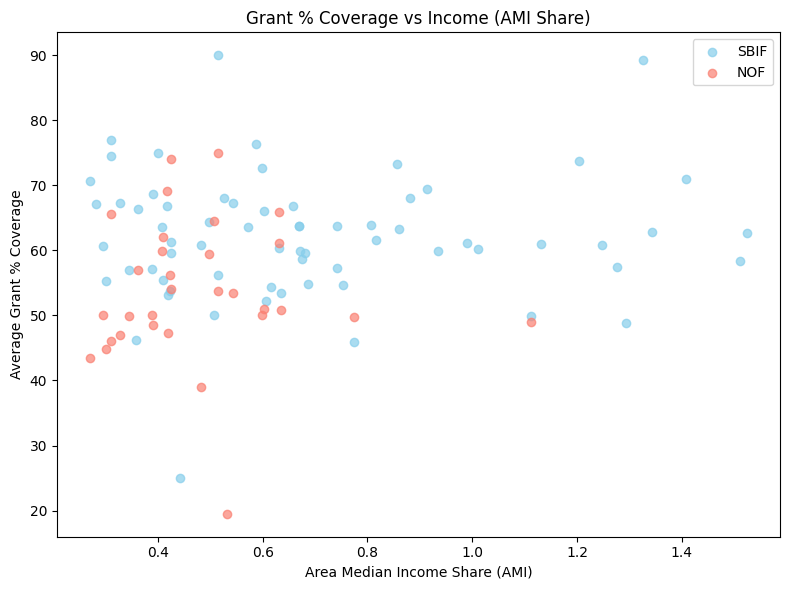

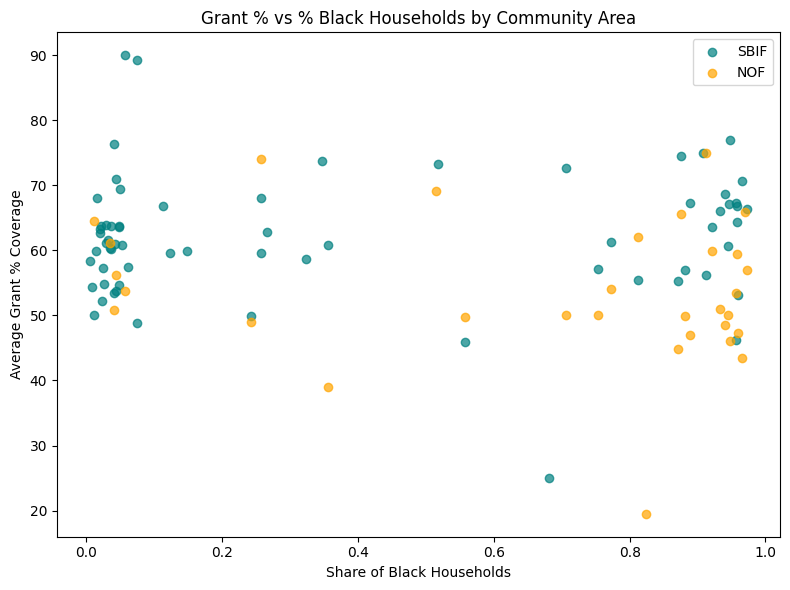

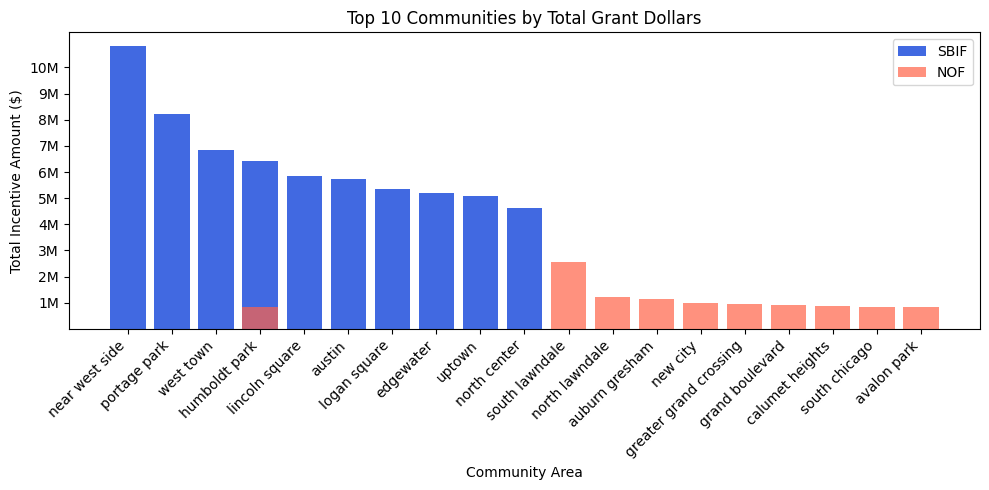

In [142]:
import matplotlib.pyplot as plt
socio = pd.read_csv("../Datasets/chi_data.csv")
socio["community_area"] = socio["community_area"].str.strip().str.lower()

sbif = dfs["sbif"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()
nof  = dfs["nof"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()

merged = socio.merge(sbif, left_on="community_area", right_on="COMMUNITY AREA", how="left") \
              .merge(nof, left_on="community_area", right_on="COMMUNITY AREA", how="left")

merged.rename(columns={"GRANT_Percent_x": "SBIF_Grant%", "GRANT_Percent_y": "NOF_Grant%"}, inplace=True)


# Saja
plt.figure(figsize=(8,6))
plt.scatter(merged["ami_shr"], merged["SBIF_Grant%"], label="SBIF", alpha=0.7, color='skyblue')
plt.scatter(merged["ami_shr"], merged["NOF_Grant%"], label="NOF", alpha=0.7, color='salmon')
plt.title("Grant % Coverage vs Income (AMI Share)")
plt.xlabel("Area Median Income Share (AMI)")
plt.ylabel("Average Grant % Coverage")
plt.legend()
plt.tight_layout()
plt.show(block=True)

# freya
plt.figure(figsize=(8,6))
plt.scatter(merged["black_hh_share"], merged["SBIF_Grant%"], label="SBIF", color='teal', alpha=0.7)
plt.scatter(merged["black_hh_share"], merged["NOF_Grant%"], label="NOF", color='orange', alpha=0.7)
plt.title("Grant % vs % Black Households by Community Area")
plt.xlabel("Share of Black Households")
plt.ylabel("Average Grant % Coverage")
plt.legend()
plt.tight_layout()
plt.show(block=True)

sbif_dollars = dfs["sbif"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]) \
    .groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum().sort_values(ascending=False).head(10)
nof_dollars = dfs["nof"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]) \
    .groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(sbif_dollars.index, sbif_dollars.values, color='royalblue', label="SBIF")
plt.bar(nof_dollars.index, nof_dollars.values, color='tomato', alpha=0.7, label="NOF")
# saja
plt.title("Top 10 Communities by Total Grant Dollars")
plt.xlabel("Community Area")
plt.ylabel("Total Incentive Amount ($)")
plt.xticks(rotation=45, ha='right')
plt.legend()

ticks = [i * 1e6 for i in range(1, 11)]
labels = [f"{i}M" for i in range(1, 11)]
plt.yticks(ticks, labels)

plt.tight_layout()
plt.show(block=True)

# Additional Machine Learning OR Stat Analysis

This will be directly on the google doc/pdf.

# Results

This will be directly on the google doc/pdf.